In [1]:
from datasets import load_dataset
from transformers import EarlyStoppingCallback, IntervalStrategy

train_ds = load_dataset("imagefolder", data_dir="data_coswara/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/1108 [00:00<?, ?it/s]

Using custom data configuration default-ceac6fd57944f9d9


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-ceac6fd57944f9d9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
696 333 78


In [21]:
# !pip install datasets
# !pip install Pillow
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install -U scikit-learn
# !pip install tensorboard
# !pip install matplotlib

In [2]:
train_ds


Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 696
})

In [5]:
import json

with open('data_coswara/label2id.json') as f:
    label2id = json.load(f)

with open('data_coswara/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'negative', 1: 'positive'}

In [6]:

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


In [7]:
feature_extractor.size

{'height': 224, 'width': 224}

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(224),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(224),
            CenterCrop(224),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [9]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [10]:
val_ds[:2]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369>],
 'classID': [0, 0],
 'class': ['negative', 'negative'],
 'pixel_values': [tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -0.7882, -0.8588, -0.8902],
           [-1.0000, -1.0000, -1.0000,  ..., -0.7725, -0.8745, -0.9608],
           [-1.0000, -1.0000, -1.0000,  ..., -0.7725, -0.8745, -0.9765]],
  
          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -0.8980, -0.9216],
           [-1.0000,

In [11]:

from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [19]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=2,
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/ubuntu/.cache/huggingface/hub


In [21]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-ecs50-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [22]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Using the latest cached version of the module from /home/ubuntu/.cache/huggingface/modules/datasets_modules/metrics/accuracy/9756d5fa4a0f9da966341741fc3926eafdc604b8276add51d5abbaa8958a25f9 (last modified on Mon Dec  5 08:03:28 2022) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.


In [23]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

In [24]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 696
})

In [25]:

# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 3712), started 0:41:35 ago. (Use '!kill 3712' to kill it.)

In [26]:
trainer.train()

/home/ubuntu/mlenv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 696
  Num Epochs = 50
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 3500
  Number of trainable parameters = 85800194


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.075484,0.987179
2,No log,0.077765,0.987179
3,No log,0.074824,0.987179
4,No log,0.079458,0.987179
5,No log,0.086632,0.987179
6,No log,0.070366,0.987179


***** Running Evaluation *****
  Num examples = 78
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-70
Configuration saved in test-ecs50-10/checkpoint-70/config.json
Model weights saved in test-ecs50-10/checkpoint-70/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-70/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 78
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-140
Configuration saved in test-ecs50-10/checkpoint-140/config.json
Model weights saved in test-ecs50-10/checkpoint-140/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-140/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 78
  Batch size = 4
Saving model checkpoint to test-ecs50-10/checkpoint-210
Configuration saved in test-ecs50-10/checkpoint-210/config.json
Model weights saved in test-ecs50-10/checkpoint-210/pytorch_model.bin
Image processor saved in test-ecs50-10/checkpoint-210/preprocessor_confi

TrainOutput(global_step=420, training_loss=0.12461197262718564, metrics={'train_runtime': 188.1522, 'train_samples_per_second': 184.957, 'train_steps_per_second': 18.602, 'total_flos': 3.236065486305362e+17, 'train_loss': 0.12461197262718564, 'epoch': 6.0})

In [27]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 333
  Batch size = 4


In [28]:
print(outputs.metrics)

{'test_loss': 0.07040545344352722, 'test_accuracy': 0.987987987987988, 'test_runtime': 5.7227, 'test_samples_per_second': 58.19, 'test_steps_per_second': 14.679}


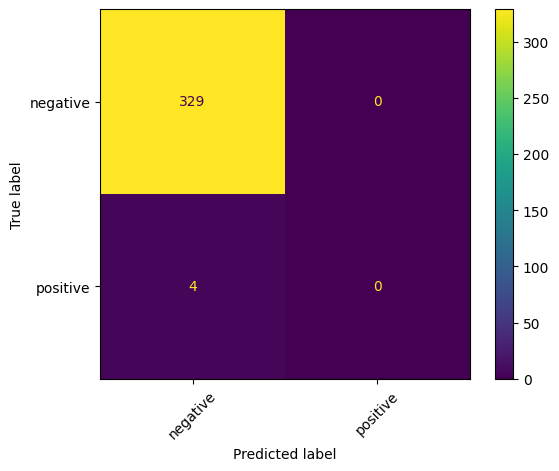

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = id2label.values()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [42]:
model.save_pretrained("/home/ubuntu/models/AudioViT_Coswa")

Configuration saved in /home/ubuntu/models/AudioViT_ECS50/config.json
Model weights saved in /home/ubuntu/models/AudioViT_ECS50/pytorch_model.bin
